# Stokes Sinker

Demonstration example for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid.

![Stokes 2D](./images/Stokes2D.gif)

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_height
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# Initialise the Model

This will set up a 2 meters x 1 meter box, the resolution is 64 x 64.

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(-1. * u.meter, -50. * u.centimeter), 
                  maxCoord=(1. * u.meter, 50. * u.centimeter))

Model.outputDir= "1_05_StokesSinker"

## Define the Materials

We define a `heavyMaterial` which will represent the background medium in which the ball will fall.
The Ball itself is defined using a `lightMaterial` with an initial disk shape.

In [5]:
lightMaterial = Model.add_material(name="Light", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
heavyMaterial = Model.add_material(name="Heavy", shape=GEO.shapes.Disk(center=(0.,30.*u.centimetre), radius=10. * u.centimetre))

### Material properties

The materials have the same viscosity but their density differs, the `heavyMaterial` is 50 times heavier than the
surrounding materials.

In [6]:
lightMaterial.density = 10 * u.kilogram / u.metre**3
heavyMaterial.density = 500 * u.kilogram / u.metre**3

lightMaterial.viscosity = 1e6 * u.pascal * u.second
heavyMaterial.viscosity = 1e6 * u.pascal * u.second

## Define Boundary Conditions

The boundary conditions are freeslip everywhere (zero shear stress).

In [7]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])

### Visualise Initial Set up


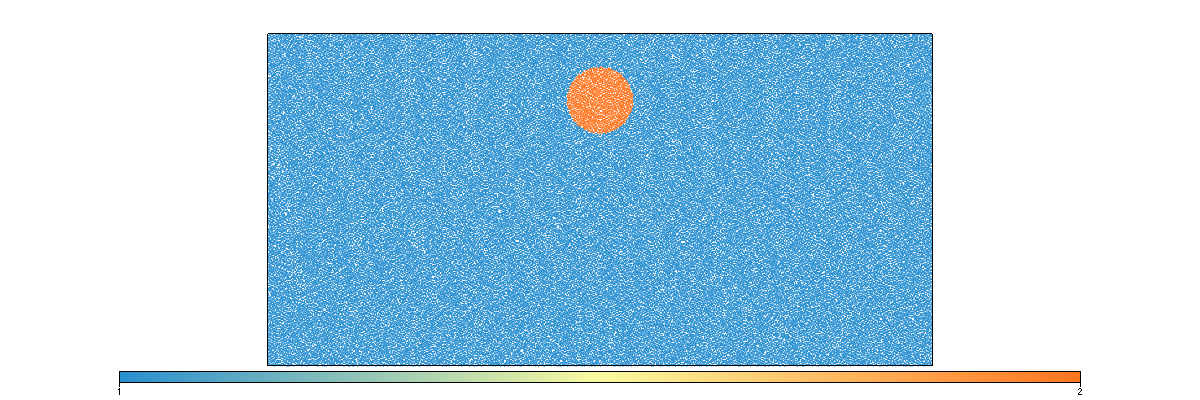

In [8]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.save("Figure_1.png")
Fig.show()

Analysis tools
-----

We define a set of metrics to monitor the evolution of the model through time.

In [9]:
import underworld as uw
import underworld.function as fn
import math

**RMS velocity**

The root mean squared velocity is defined by intergrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $V$ denotes the volume of the box.

In [10]:
vdotv = fn.math.dot(Model.velocityField, Model.velocityField)
v2sum_integral  = uw.utils.Integral(mesh=Model.mesh, fn=vdotv )
volume_integral = uw.utils.Integral(mesh=Model.mesh, fn=1. )
vrms = math.sqrt(v2sum_integral.evaluate()[0] / volume_integral.evaluate()[0])

**Position of the bottom of the Ball**

We will use a passive tracers, initially located at the bottom of the disk.
Note that because the ball is going to deform, the position of the passive tracers may change lateraly.
In practice this is very minimal.

In [11]:
x0, y0 = 0, 20. * u.centimetre
Model.add_passive_tracers(name="tip", vertices=[x0, y0])

Once the tools have been defined, we need a way to get them to execute after each time step.
This can be done using the `Model.postSolveHook` entry point. 

We need to define a python function that will process the output of Model and extract information: In the following we define 2 containers in the form of python list objects. The position of the passive tracers and the vrms will be appended to their respective list after each timestep using the `post_solve_hook` python function. Note that the lists must be defined as global inside the python function so that we can retrieve them.

In [12]:
tSinker = [0.]
ypos = Model.tip_tracers.swarm.particleCoordinates.data[:,1][0]
ypos = GEO.Dimensionalize(ypos, u.centimetre)
ypos = ypos.magnitude
ySinker = [ypos]
vrms = [math.sqrt(v2sum_integral.evaluate()[0] / volume_integral.evaluate()[0])]

def post_solve_hook():
    global tSinker
    global ySinker
    global vrms
    
    time = Model.time.to(u.hour).magnitude
    ypos = Model.tip_tracers.swarm.particleCoordinates.data[:,1][0]
    ypos = GEO.Dimensionalize(ypos, u.centimetre)
    ypos = ypos.magnitude
    
    tSinker.append(time)
    ySinker.append(ypos)
    vrms.append(math.sqrt(v2sum_integral.evaluate()[0] / volume_integral.evaluate()[0]))

The `post_solve_hook` function is "attached" to `Model.postSolveHook`

In [13]:
Model.postSolveHook = post_solve_hook

In [14]:
Model.init_model()

In [15]:
Model.run_for(13.0 * u.hours, checkpoint_interval=5.*u.minutes)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:     1 Model Time: 0.08 hour dt: 5.00 minute (2018-11-28 07:20:27)
Step:     2 Model Time: 0.17 hour dt: 5.00 minute (2018-11-28 07:20:29)
Step:     3 Model Time: 0.25 hour dt: 5.00 minute (2018-11-28 07:20:32)
Step:     4 Model Time: 0.33 hour dt: 5.00 minute (2018-11-28 07:20:35)
Step:     5 Model Time: 0.42 hour dt: 5.00 minute (2018-11-28 07:20:38)
Step:     6 Model Time: 0.50 hour dt: 5.00 minute (2018-11-28 07:20:41)
Step:     7 Model Time: 0.58 hour dt: 5.00 minute (2018-11-28 07:20:44)
Step:     8 Model Time: 0.67 hour dt: 5.00 minute (2018-11-28 07:20:47)
Step:     9 Model Time: 0.75 hour dt: 5.00 minute (2018-11-28 07:20:50)
Step:    10 Model Time: 0.83 hour dt: 5.00 minute (2018-11-28 07:20:53)
Step:    11 Model Time: 0.92 hour dt: 5.00 minute (2018-11-28 07:20:56)
Step:    12 Model Time: 1.00 hour dt: 5.00 minute (2018-11-28 07:20:59)
Step:    13 Model Time: 1.08 hour dt: 5.00 minute (2018-11-28 07:21:0

Step:   114 Model Time: 9.50 hour dt: 5.00 minute (2018-11-28 07:26:52)
Step:   115 Model Time: 9.58 hour dt: 5.00 minute (2018-11-28 07:26:56)
Step:   116 Model Time: 9.67 hour dt: 5.00 minute (2018-11-28 07:26:59)
Step:   117 Model Time: 9.75 hour dt: 5.00 minute (2018-11-28 07:27:02)
Step:   118 Model Time: 9.83 hour dt: 5.00 minute (2018-11-28 07:27:06)
Step:   119 Model Time: 9.92 hour dt: 5.00 minute (2018-11-28 07:27:09)
Step:   120 Model Time: 10.00 hour dt: 5.00 minute (2018-11-28 07:27:12)
Step:   121 Model Time: 10.08 hour dt: 5.00 minute (2018-11-28 07:27:15)
Step:   122 Model Time: 10.17 hour dt: 5.00 minute (2018-11-28 07:27:18)
Step:   123 Model Time: 10.25 hour dt: 5.00 minute (2018-11-28 07:27:21)
Step:   124 Model Time: 10.33 hour dt: 5.00 minute (2018-11-28 07:27:24)
Step:   125 Model Time: 10.42 hour dt: 5.00 minute (2018-11-28 07:27:28)
Step:   126 Model Time: 10.50 hour dt: 5.00 minute (2018-11-28 07:27:31)
Step:   127 Model Time: 10.58 hour dt: 5.00 minute (2018-

1

## Visualisation of the results

**Material Field**


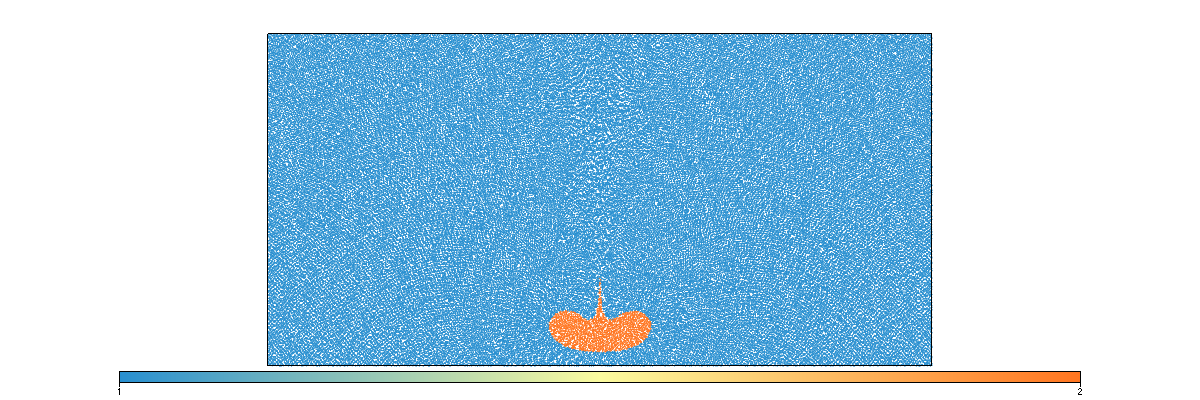

In [16]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.save("Figure_2.png")
Fig.show()

**Velocity Field**

The following plot combine the velocity field magnitude, calculated as the dot product of the velocity field (`Model.velocityField`) and vector arrows. The results are in non-dimensional units, one can change that as follow:


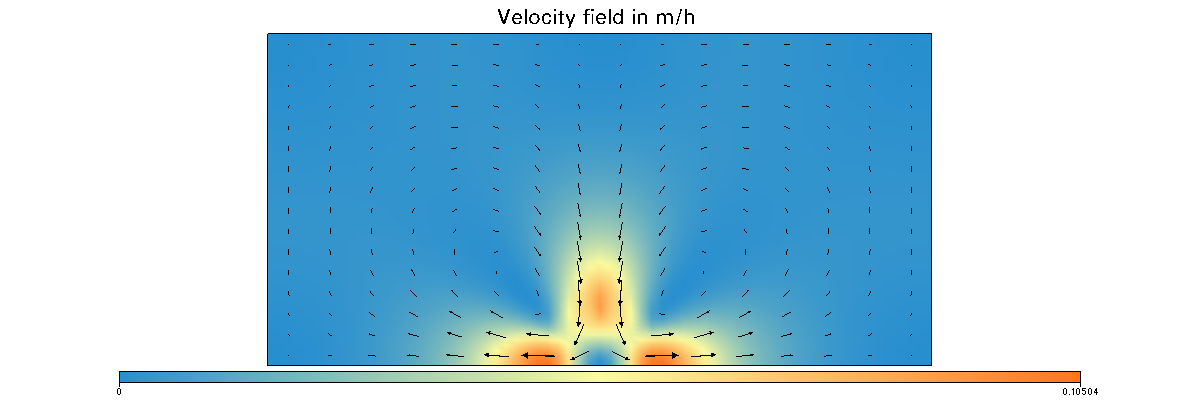

In [17]:
# Calculate the velocity magnitude
velocityMag = fn.math.dot(Model.velocityField, Model.velocityField)
# Get a conversion factor to units of m/hr
fact = GEO.Dimensionalize(1.0, u.metre / u.hour).magnitude
# Apply the factor to the velocity Magnitude
velocityMag *= fact

Fig = glucifer.Figure(figsize=(1200,400), title="Velocity field in m/h")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_3.png")
Fig.show()

**Strain Rate**

The strain rate is actually an `underworld.meshVariable`, it is defined on the `mesh` and can thus be scaled directly to SI units using the `GEO.Dimensionalize` function:


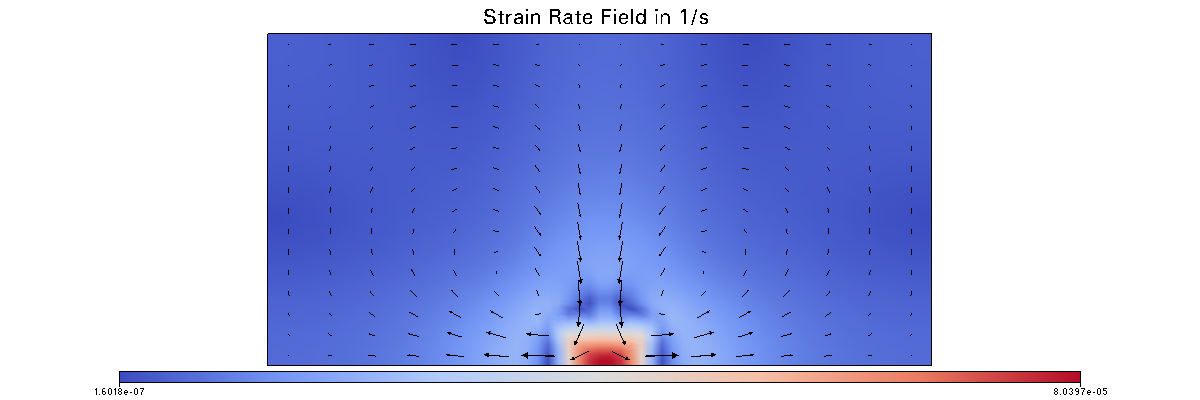

In [18]:
Fig = glucifer.Figure(figsize=(1200,400), title="Strain Rate Field in 1/s")
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.strainRateField, 1.0 / u.second), colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_4.png")
Fig.show()

# Quick Analysis

The position of the Sinker through time can be plotted using the `tSinker` and `ySinker` lists.

Here we use Matplotlib to make the plot. Matplotlib is not parallel safe and will return message errors when attempting to run
this Model on multiple processors. To avoid this, the user will need to run the Matplotlib function on one CPUs.
This can be achieved using a condition on the processor `rank`:

In [19]:
if(uw.rank()==0):
    import matplotlib.pyplot as plt
    plt.plot(tSinker, ySinker, "o") 
    plt.plot(tSinker, ySinker) 
    plt.xlabel('Time')
    plt.ylabel('Sinker position')
    plt.show()

<Figure size 640x480 with 1 Axes>